# CMF Macro Part-1.1

Last time we constructed and reorganised commodities data we got from International Monetary Fund. This time we improve our models.
Let's load our data and take a look at it:

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/commodities_with_date.csv')

In [3]:
df.head()

,APSP crude oil($/bbl),Diammonium phosphate,Palm Oil,Swine,Fish,"Tea, Kolkata","Vegetables, Tomato",Brent Crude,Fish Meal,"Natural gas, EU",...,Aluminum,Bananas,Barley,Soft Logs,"Hard Logs, Import Price Japan",Cobalt,Cotton,"Coal, Australia","Tea, Kenyan",Date
0,20.365072,148.000000,230.555951,93.147106,5.204495,264.25,0.0,20.989130,652.059130,1.73,...,1528.0,589.7,75.568672,121.556919,156.039993,7630.000114,75.200012,38.0,252.929993,1990-01-01
1,19.528833,145.800000,223.945027,80.003995,5.646819,276.73,0.0,19.702500,670.168850,1.73,...,1454.0,644.9,73.864701,121.308280,153.100006,7659.999847,75.959991,38.0,211.289993,1990-02-01
2,18.220758,160.909091,236.340509,79.910116,5.610611,260.69,0.0,18.465909,641.984523,1.73,...,1567.0,538.5,70.044579,128.017488,145.550003,8029.998779,78.899994,38.0,192.600006,1990-03-01
3,16.567778,175.619048,220.639566,99.643558,5.631545,286.57,0.0,16.926190,647.403119,2.11,...,1526.0,584.2,68.769082,127.257046,145.139999,8229.999542,82.869995,38.0,194.809998,1990-04-01
4,16.587536,168.739130,232.208681,115.678154,5.798833,330.37,0.0,16.671739,663.067609,2.11,...,1527.0,494.4,71.026076,130.367009,155.669998,8150.001526,85.600006,40.5,187.020004,1990-05-01


# Correlation and Choosing Features

The goal is to determine key features that affect our target "APSP crude oil($/bbl)". That will help us in building more precise and robust models.
first step is to address the correlation matrix of all dataset features, and plotting it using seaborn package.

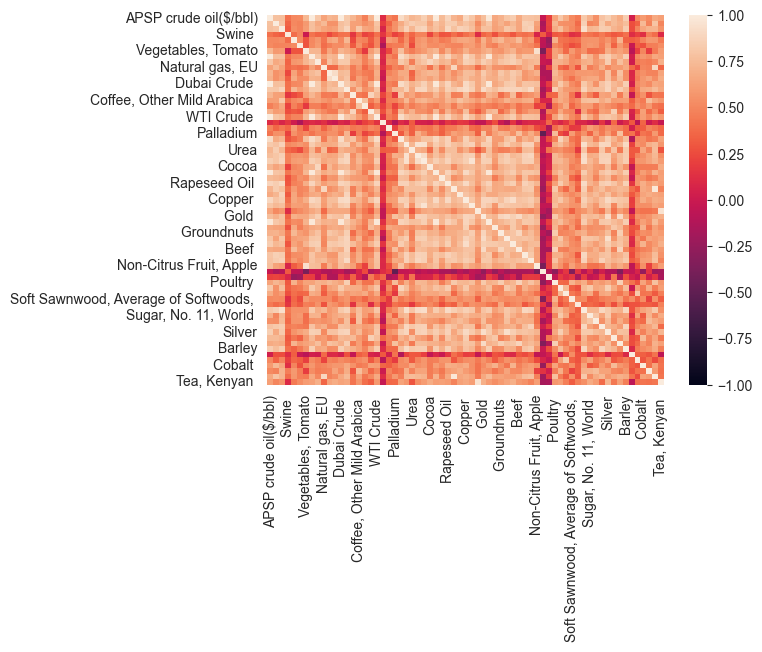

In [4]:
import seaborn as sns

sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False);

The problem with choosing potential features is their pairwise correlation, to overcome that we establish threshold for wanted correlation with target, and another one - maximum possible correlation within pair:

In [5]:
correlations = df.corr()
crude_corr = dict(correlations['APSP crude oil($/bbl)'])

crude_corr_threshold = .7
two_features_corr_threshold = .45

features = df.columns[:-1]
high_corr_pairs = []  # pair of features with high correlation with US crude which also highly correlated


for feature_1 in features:
    if crude_corr[feature_1] > crude_corr_threshold:

        for feature_2 in features:
            if (feature_2 != feature_1) and (crude_corr[feature_2] > crude_corr_threshold):

                corr12 = correlations[feature_1][feature_2]

                if (abs(corr12) < two_features_corr_threshold) \
                        and ('rude' not in feature_1) and ('rude' not in feature_2) \
                        and ('Gasoline' not in feature_1) and ('Gasoline' not in feature_2):

                    high_corr_pairs.append((feature_1, feature_2, corr12))

In [6]:
len(high_corr_pairs)

14

In [7]:
number_of_appearances_dict = {}
for pair in high_corr_pairs:
    number_of_appearances_dict[pair[0]] = number_of_appearances_dict.get(pair[0], 0) + 1
    number_of_appearances_dict[pair[1]] = number_of_appearances_dict.get(pair[1], 0) + 1

In [8]:
number_of_appearances_dict.keys()

dict_keys(['Vegetables, Tomato', 'Wheat ', 'Wool, Coarse ', 'Nickel ', 'Urea', 'Uranium ', 'Groundnuts ', 'Soybean Meal ', 'Cocoa'])

Thus we found the following commodities:
+ Food products: Tomatoes, Wheat, Groundnuts, Soybean, Cocoa
+ Wool
+ Nickel, Uranium
+ Urea

And now we'll work with dataset on chosen features only:

In [9]:
features_corr = list(number_of_appearances_dict.keys())
features_corr.append('Date')
features_corr.append('APSP crude oil($/bbl)')

In [10]:
df_chosen1 = df[features_corr]
#df_chosen1.index = df_chosen1['Date']

In [11]:
df_chosen1.head()

,"Vegetables, Tomato",Wheat,"Wool, Coarse",Nickel,Urea,Uranium,Groundnuts,Soybean Meal,Cocoa,Date,APSP crude oil($/bbl)
0,0.0,167.918579,501.128824,7056.0,124.055556,9.00,864.35,191.306128,995.0,1990-01-01,20.365072
1,0.0,160.937271,494.864714,6977.0,125.600000,8.80,823.75,182.267175,1022.0,1990-02-01,19.528833
2,0.0,156.528030,488.600604,9267.0,122.500000,8.80,795.91,184.328497,1131.0,1990-03-01,18.220758
3,0.0,159.467529,482.336493,8939.0,120.476190,8.65,761.43,191.063619,1336.0,1990-04-01,16.567778
4,0.0,149.179291,447.257476,8698.0,118.782609,9.35,768.48,199.970295,1443.0,1990-05-01,16.587536


In [12]:
date = '2019-01-01'
norwgd = int(df_chosen1[df_chosen1.Date == date].index[0])
'''Number of Row with given date, will use it to divide dataset'''
norwgd

348

We'll use the similar way to implement Lasso regression and determine key features that affect our target.
So we import it from individual file:

In [13]:
X, y = df_chosen1.drop(columns=['APSP crude oil($/bbl)', 'Date']), df_chosen1['APSP crude oil($/bbl)']
X_train, X_test, y_train, y_test = X[X.index < norwgd], X[X.index >= norwgd], y[y.index < norwgd], y[y.index > norwgd]

In [14]:
import LassoChoosingTeam
%load_ext autoreload
%autoreload 2

In [ ]:
importance, team = LassoChoosingTeam.lasso_get_features(df_chosen1, X, y, X_train, X_test, y_train, y_test)

In [16]:
print(importance)
print(team)

[7.08565326 4.42979    2.65158825 4.3540161  6.71483964 0.
 1.9809029  8.28372124 0.        ]
['Vegetables, Tomato' 'Wheat ' 'Wool, Coarse ' 'Nickel ' 'Urea'
 'Groundnuts ' 'Soybean Meal ']


Thus, our key features are:
+ Tomato
+ Wheat
+ Wool
+ Nickel
+ Urea
+ Groundnuts
+ Soybeans

### Remember to take into account the possibility to vary thresholds of feature's correlation as well as pairwise ones. (cell #5)
